## Computer Vision

In [48]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from helper_functions import accuracy_fn

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.0.0+cu117
torchvision version: 0.15.1+cu117


In [52]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [35]:
train_data = datasets.FashionMNIST(
    root="data/",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data/",
    train=False,
    download=True,
    transform=ToTensor()
)

In [36]:
image, label = train_data[0]
print(f"{image.shape}, number: {label}")
print(len(train_data.data), len(test_data))

torch.Size([1, 28, 28]), number: 9
60000 10000


In [37]:
# Multiclass classification

class_names = train_data.classes

Text(0.5, 1.0, 'Ankle boot')

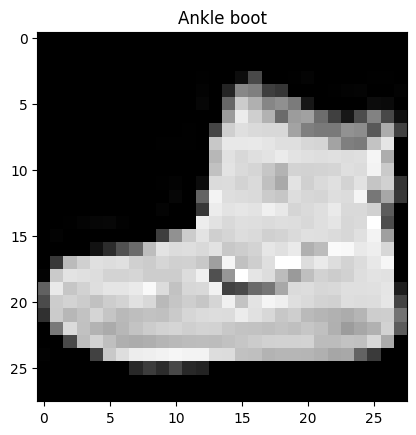

In [38]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

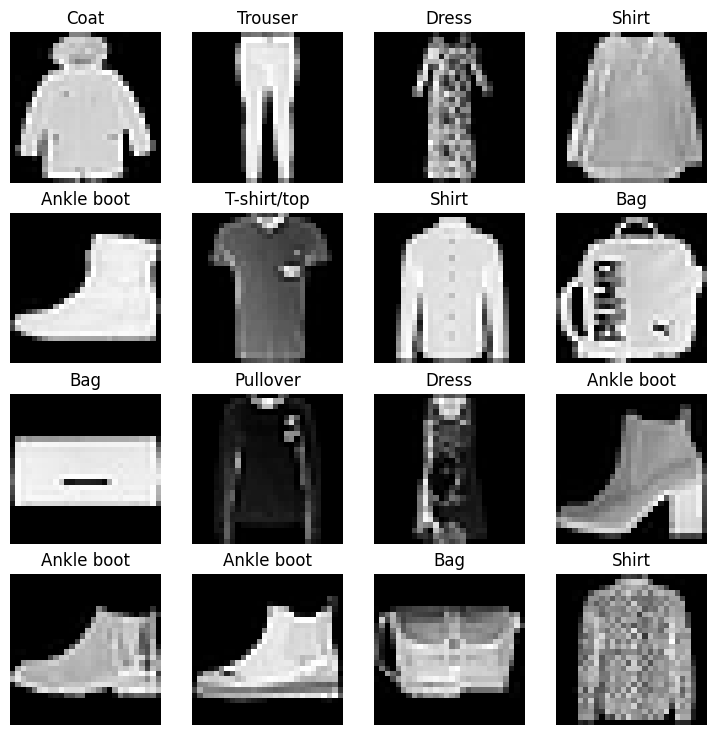

In [39]:
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows*cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [40]:
BATCH_SIZE = 32

train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)
test_dataloader = DataLoader(
    test_data, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


## Building the model

In [72]:
class ImageModel(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [73]:
model = ImageModel(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(device)



In [43]:
import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [59]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [60]:
from tqdm.auto import tqdm

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch n. {epoch}")
    
    # Training 
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    
    # Testing 
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            y_pred  = model(X)
            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

        

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch n. 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|███▎      | 1/3 [00:12<00:24, 12.23s/it]


Train loss: 0.58514 | Test loss: 0.50979, Test acc: 81.85%

Epoch n. 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|██████▋   | 2/3 [00:20<00:09,  9.94s/it]


Train loss: 0.47434 | Test loss: 0.49757, Test acc: 82.86%

Epoch n. 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 3/3 [00:28<00:00,  9.46s/it]


Train loss: 0.45360 | Test loss: 0.46423, Test acc: 83.80%



In [67]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

In [62]:
model_results = eval_model(
    model=model, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn
)
model_results

{'model_name': 'CNNModel',
 'model_loss': 0.46386948227882385,
 'model_acc': 83.8158945686901}

In [74]:
class ImageModel2(nn.Module):
    def __init__(self, input, hidden, output, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, hidden),
            nn.ReLU(),
            nn.Linear(hidden, output),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [75]:
model2 = ImageModel2(784, 10, len(class_names)).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model2.parameters(), lr=0.1)


In [68]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for (X, y) in data_loader:
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [69]:
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model2, 
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.49299 | Train accuracy: 82.06%


 33%|███▎      | 1/3 [00:07<00:15,  7.59s/it]

Test loss: 0.43832 | Test accuracy: 84.18%

Epoch: 1
---------
Train loss: 0.41890 | Train accuracy: 85.06%


 67%|██████▋   | 2/3 [00:15<00:07,  7.67s/it]

Test loss: 0.44062 | Test accuracy: 84.50%

Epoch: 2
---------
Train loss: 0.40918 | Train accuracy: 85.35%


100%|██████████| 3/3 [00:22<00:00,  7.56s/it]

Test loss: 0.43640 | Test accuracy: 84.12%



In [71]:
model_1_results = eval_model(model=model2, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn,
    device=device) 
model_1_results

{'model_name': 'CNNModel2',
 'model_loss': 0.4366539418697357,
 'model_acc': 84.09544728434504}